<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/Memoria_experiment2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aplicamos las técnicas de preprocesamiento y las entrenamos con una red densa

In [ ]:
!python -m spacy download es_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
tqdm.pandas()

from numpy.random import seed
seed(9)

import tensorflow as tf
tf.random.set_seed(9)

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")

import nltk
from nltk.tokenize import WordPunctTokenizer
import keras
import re
import string
from collections import Counter

nltk.download("popular")
nltk.download('stopwords')
print(tf.__version__)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [ ]:
df = pd.read_csv("gdrive/My Drive/TFG/overviews_final.csv", sep='#',encoding='utf-8', lineterminator='\n')

df['text_array'] = df.overview.str.split(" ")
df['n_words'] = df['text_array'].apply(lambda x: len(x))
df = df.drop(columns=['text_array'])
#df = df[df['n_words']>15]

df.shape

(2043, 10)

In [ ]:
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: eval(x))

In [ ]:
# Count
ini_n_words = len(Counter(" ".join(df.overview).split()))

In [ ]:
# Normalización

def normalize(x):
  x = x.lower()
  replacements = (
      ("á", "a"),
      ("é", "e"),
      ("í", "i"),
      ("ó", "o"),
      ("ú", "u"),
      ("ñ", "n")
  )
  for a, b in replacements:
      x = x.replace(a, b)

  x = x.translate(str.maketrans('','',string.punctuation))
  x = x.translate(str.maketrans('','','ªº¡¿'))   
  x = x.replace("  ", " ") 
  return x

In [ ]:
df['overview'] = df['overview'].progress_apply(lambda x: normalize(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [normalize(i) for i in x])

In [ ]:
# Count
normalize_n_words = len(Counter(" ".join(df.overview).split()))

In [ ]:
# Stop_words

stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist()
stop_words = [normalize(word) for word in stop_words]

def delete_stop_words(x):
  words = x.split(' ')
  words = [word for word in words if word not in stop_words]
  x = str(' '.join(words))
  return x

In [ ]:
df['overview'] = df['overview'].progress_apply(lambda x: delete_stop_words(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [delete_stop_words(i) for i in x])

In [ ]:
# Count
sw_n_words = len(Counter(" ".join(df.overview).split()))

In [ ]:
# Lemmatization

import spacy

nlp = spacy.load('es_core_news_sm')

def lemmatize_sentece(sentence):  
  doc = nlp(sentence)
  return ' '.join([word.lemma_ for word in doc])

In [ ]:
df_lemma = df.copy()
df_lemma['overview'] = df['overview'].progress_apply(lambda x: lemmatize_sentece(x))
df_lemma['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [lemmatize_sentece(i) for i in x])

In [ ]:
# Count
lemma_n_words = len(Counter(" ".join(df_lemma.overview).split()))

In [ ]:
# Steaming

from nltk import word_tokenize
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("spanish", ignore_stopwords=True)

def stem_sentence(sentence):
  stemmed_text = [stemmer.stem(word) for word in word_tokenize(sentence)]
  return " ".join(stemmed_text)

In [ ]:
df['overview'] = df['overview'].progress_apply(lambda x: stem_sentence(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [stem_sentence(i) for i in x])

In [ ]:
df_lemma['overview'] = df_lemma['overview'].progress_apply(lambda x: stem_sentence(x))
df_lemma['new_overviews'] = df_lemma['new_overviews'].progress_apply(lambda x: [stem_sentence(i) for i in x])

In [ ]:
# Count
stemming_n_words = len(Counter(" ".join(df.overview).split()))
stemming_lemma_n_words = len(Counter(" ".join(df_lemma.overview).split()))

In [ ]:
step = ['Inicio', 'Norm.', 'Stop Words', 'Lemmatization', 'Steamming', 'Lemma. + Steam.']
n_words = [ini_n_words, normalize_n_words, sw_n_words, lemma_n_words, stemming_n_words, stemming_lemma_n_words]

data_count = {
    'Preprocesamiento': step,
    'N palabras': n_words
}

df_count = pd.DataFrame(data=data_count)

In [ ]:
df_count

,Preprocesamiento,N palabras
0,Inicio,28558
1,Norm.,19398
2,Stop Words,18936
3,Lemmatization,14026
4,Steamming,11914
5,Lemma. + Steam.,11530


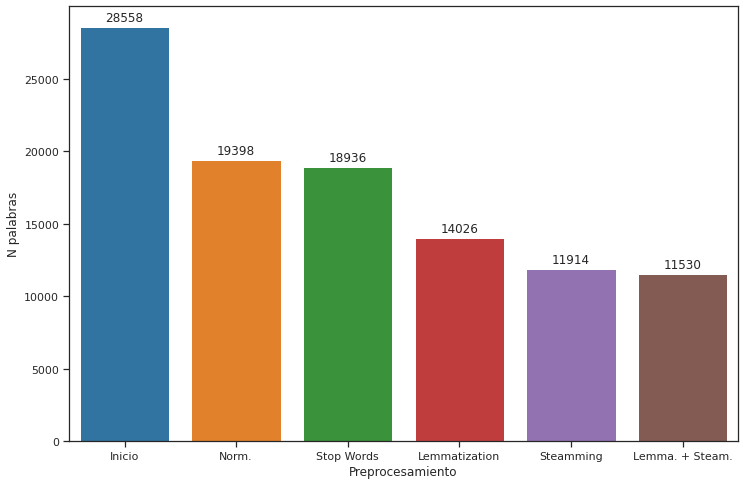

In [ ]:
# https://datavizpyr.com/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/

fig, ax = plt.subplots(figsize=(12, 8))
splot = sns.barplot(x="Preprocesamiento", y="N palabras", data=df_count, ax=ax)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

Eligimos combinación (Norm. + SW + Stemming) es la manera más equilibrada en cuanto a rendimiento y cantidad de vocabulario que reducimos. Descartamos por tanto aplicar Lemma.

Nos queamos con un vocabulario de 8491

## Con text augmentation

In [ ]:
X = df.drop(columns=['like'])
y = df['like']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=10)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/90, stratify=y_train, random_state=10) 

X_test = X_test['overview']
y_test = y_test.values

#X_val = X_val['overview']
#y_val = y_val.values

In [ ]:
X_test.head(5)

1209    hombr garaj constru aparat alt complej acciden...
2015    aloys adorn detectiv priv taciturn lob solitar...
722     criminal procedent planet krypton padr superm ...
525     biograf retrat juventud jan aust anne hathaway...
1237    mystery pequen aisl puebl alask cuy acontec ca...
Name: overview, dtype: object

In [ ]:
X_train_new = X_train['overview'].copy()
y_train_new = y_train.copy()

for i in range(0, len(X_train)):
  new_series_X = pd.Series(X_train.iloc[i]['new_overviews'])
  X_train_new = X_train_new.append(new_series_X, ignore_index=True)

  y_value = y_train.iloc[i]
  new_series_y = pd.Series([y_value, y_value])
  y_train_new = y_train_new.append(new_series_y, ignore_index=True)

y_train_new = y_train_new.values

In [ ]:
# Count
corpus_augment = ""
for i in range(0, len(df)):
  corpus_augment = corpus_augment + " ".join(df.iloc[i]['new_overviews'])

full_corpus = " ".join(df['overview']) + "" + corpus_augment
augm_n_words = len(Counter(full_corpus.split()))
augm_n_words

15863

In [ ]:
step = ['Inicio', 'Norm. + S.W. + Steam.', 'Text Aug.']
n_words = [ini_n_words, stemming_n_words, augm_n_words]

data_count = {
    'Preprocesamiento': step,
    'N palabras': n_words
}

df_count = pd.DataFrame(data=data_count)

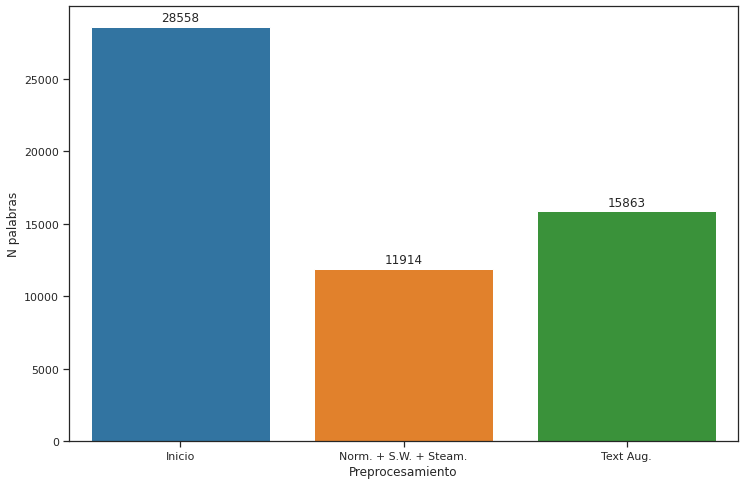

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
splot = sns.barplot(x="Preprocesamiento", y="N palabras", data=df_count, ax=ax)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')